In [167]:
import os, pathlib
import numpy as np
import neuropythy as ny
import matplotlib as mpl, matplotlib.pyplot as plt
import ipyvolume as ipv
import pandas as pd

from neuropythy.geometry.util import triangle_area

In [168]:
# The save directory where we load the ventral ROI labels from.
ventral_label_path = '~/code/hcp-annot-vc_data/save'

# The following code is for loading in the ventral ROI labels.
def load_ventral_pathaddr(rater, sid, h, lbl):
    p = pathlib.Path(ventral_label_path).expanduser()
    p = p / rater / str(sid)
    return ny.load(str(p / f"{h}.{lbl}_path.json.gz"))
def load_ventral_pathaddrs(rater, sid, h):
    rois = {}
    for k in ['hV4', 'VO1', 'VO2']:
        rois[k] = load_ventral_pathaddr(rater, sid, h, k)
    return rois
def load_ventral_paths(rater, sid, h):
    addrs = load_ventral_pathaddrs(rater, sid, h)
    hem = ny.data['hcp_lines'].subjects[sid].hemis[h]
    return {k: ny.geometry.Path(hem, path)
            for (k,path) in addrs.items()}
def load_ventral_labels(rater, sid, h):
    paths = load_ventral_paths(rater, sid, h)
    lbls = {}
    for (k,path) in paths.items():
        lbl = (path.label > 0.5)
        if np.sum(lbl) > np.sum(~lbl):
            lbl = ~lbl
        lbls[k] = lbl
    return lbls

In [10]:
# This is the sample rater and subject/hemisphere we will be using.
rater = 'lindazelinzhao'
sid = 102311
h = 'lh'

# Get the subject and hemisphere object, and the midgray surface.
sub = ny.data['hcp_lines'].subjects[sid]
hem = sub.hemis[h]
surf = hem.surface('midgray')

# Load the labels for visual areas and combine them.
ventral_labels = load_ventral_labels(rater, sid, h)
early_labels = {f'V{k}': hem.prop('visual_area') == k
                for k in [1,2,3]}
labels = dict(ventral_labels)
labels.update(early_labels)

In [35]:
surf.tess.faces

array([[     0,      4,      0, ..., 131647, 132557, 132992],
       [     1,      3,     50, ..., 132558, 132545, 132133],
       [     3,      1,     51, ..., 132123, 132544, 132558]])

In [36]:
(corner1, corner2, corner3) = surf.tess.faces

In [39]:
(vertex_x, vertex_y, vertex_z) = surf.coordinates

In [41]:
face0_a = corner1[0]
face0_b = corner1[1]
face0_c = corner1[2]

(vertex_x[face0_a], vertex_y[face0_a], vertex_z[face0_a])

(-14.739158, -97.410095, 8.203468)

In [56]:
corner_coords = surf.coordinates[:, surf.tess.faces]
corner_coords = np.transpose(corner_coords, (1,0,2))

In [57]:
corner_coords.shape

(3, 3, 273694)

In [59]:
# Get the coordinates for the first triangle:
# (a_xyz, b_xyz, c_xyz) = corner_coords[:,:,0]

(a, b, c) = corner_coords

In [77]:
face_areas = triangle_area(a, b, c)

In [78]:
face_areas

array([0.16524176, 0.20039554, 0.2609294 , ..., 0.2925599 , 0.29793352,
       0.85141593], dtype=float32)

In [83]:
vis_x = surf.prop('prf_x')
vis_y = surf.prop('prf_y')
vis_coords = np.array([vis_x, vis_y])

In [84]:
corner_vis_coords = vis_coords[:, surf.tess.faces]
corner_vis_coords = np.transpose(corner_vis_coords, (1,0,2))

In [85]:
corner_vis_coords.shape

(3, 2, 273694)

In [86]:
(vis_a, vis_b, vis_c) = corner_vis_coords

In [87]:
face_vis_areas = triangle_area(vis_a, vis_b, vis_c)

In [88]:
face_vis_areas.shape

(273694,)

/home/nben/.conda/envs/nben/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nben/.conda/envs/nben/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.54057e+05, 2.26300e+03, 6.63000e+02, 3.77000e+02, 8.30000e+01,
        4.80000e+01, 2.10000e+01, 8.00000e+00, 1.00000e+01, 6.00000e+00]),
 array([  0.      ,  32.51551 ,  65.03102 ,  97.546524, 130.06204 ,
        162.57755 , 195.09305 , 227.60857 , 260.12408 , 292.6396  ,
        325.1551  ], dtype=float32),
 <a list of 10 Patch objects>)

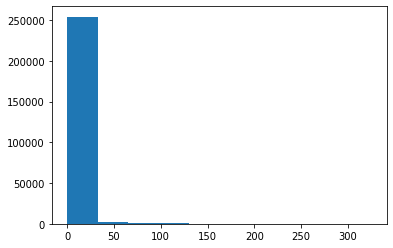

In [89]:
plt.hist(face_vis_areas)

In [91]:
cmag = face_areas / face_vis_areas

<ipython-input-91-3a105c3782d0>:1: RuntimeWarning: divide by zero encountered in true_divide
  cmag = face_areas / face_vis_areas


In [92]:
cmag

array([inf, inf, inf, ..., inf, inf, inf], dtype=float32)

(array([42308.,  2468.,  1594.,  1056.,   802.,   620.,   509.,   439.,
          344.,   302.]),
 array([2.2349953e-04, 4.9938625e+01, 9.9877029e+01, 1.4981543e+02,
        1.9975383e+02, 2.4969223e+02, 2.9963065e+02, 3.4956903e+02,
        3.9950745e+02, 4.4944583e+02, 4.9938425e+02], dtype=float32),
 <a list of 10 Patch objects>)

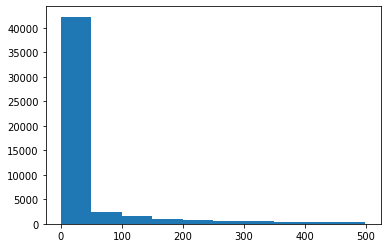

In [94]:
finite_cmag = cmag[np.isfinite(cmag)]
plt.hist(finite_cmag[finite_cmag < 500])

In [95]:
def ring_area_deg2(min_eccen, max_eccen, hemifield=False):
    """Computes the area (in square degrees) of a ring in the visual field."""
    if hemifield:
        return (np.pi * max_eccen**2 - np.pi * min_eccen**2) / 2
    else:
        return np.pi * max_eccen**2 - np.pi * min_eccen**2

In [96]:
sub = ny.data['hcp_lines'].subjects[111312]
lh = sub.lh

In [101]:
eccen = lh.prop('prf_eccentricity')
label = lh.prop('visual_area')
sarea = lh.prop('surface_area')

In [102]:
sarea

array([0.33886254, 0.3088855 , 0.34559762, ..., 0.36263546, 0.17667758,
       0.09788544], dtype=float32)

In [106]:
def cmag_at_eccen(hemi, target_eccen, vertex_eccen, mask, width=1):
    # Calculate the area of the ring in the visual field:
    min_eccen = target_eccen - width/2
    max_eccen = target_eccen + width/2
    area_vis = ring_area_deg2(min_eccen, max_eccen, hemifield=True)
    # Next, find the vertices inside the ring:
    vertices_in_ring = mask & (vertex_eccen > min_eccen) & (vertex_eccen < max_eccen)
    # Sum up the vertex areas of vertices in the ring:
    area_surf = hemi.prop('surface_area')[vertices_in_ring]
    area_surf = np.sum(area_surf)
    # Now we have area on the surface and area in the visual field, so just divide:
    return area_surf / area_vis

In [107]:
v1_mask = (label == 1)

In [108]:
cmag_at_eccen(lh, 3, eccen, v1_mask)

<ipython-input-106-2a5dd99d74db>:7: RuntimeWarning: invalid value encountered in greater
  vertices_in_ring = mask & (vertex_eccen > min_eccen) & (vertex_eccen < max_eccen)
<ipython-input-106-2a5dd99d74db>:7: RuntimeWarning: invalid value encountered in less
  vertices_in_ring = mask & (vertex_eccen > min_eccen) & (vertex_eccen < max_eccen)


15.351705602851709

This is the Horton and Hoyt Equation for cortical magnification in V1:

$m(e) = (17.3 / (0.75 + e))^2$ ($e$ is eccentricity in degrees, $m(e)$ is cortical magnification in square mm per square deg)

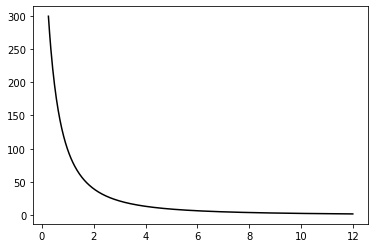

In [117]:
e = np.linspace(0.25, 12, 500)
plt.plot(e, (17.3 / (0.75 + e))**2, 'k-')

In [118]:
cmag = [cmag_at_eccen(lh, x, eccen, v1_mask, width=x/2) for x in e]

<ipython-input-106-2a5dd99d74db>:7: RuntimeWarning: invalid value encountered in greater
  vertices_in_ring = mask & (vertex_eccen > min_eccen) & (vertex_eccen < max_eccen)
<ipython-input-106-2a5dd99d74db>:7: RuntimeWarning: invalid value encountered in less
  vertices_in_ring = mask & (vertex_eccen > min_eccen) & (vertex_eccen < max_eccen)


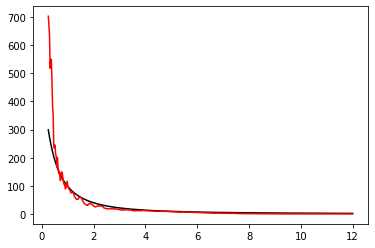

In [120]:
(fig, ax) = plt.subplots(1, 1)
ax.plot(e, (17.3 / (0.75 + e))**2, 'k-')
ax.plot(e, cmag, 'r-')

```
f(x,y) = z
▽f(x,y) = [df/dx, df/dy]

h(x,y) = [z,w]

Jac{f}(x,y) = [[dz/dx, dz/dy], [dw/dx, dw/dy]]

---

cortex(x,y) -> visual_field(x,y)

vision(cx, cy) = [vx, vy]

Jac{vision}(cx,cy) = [[d vx/cx, d vy/cx], [d vx/cy, d vy/cy]]
```

In [2]:
import neuropythy as ny

In `neuropythy.vision` module are functions for calculating cortical magnification (`cmag`) and "visual" magnification (`vmag`).

Visual magnification is just the inverse of cortical magnification: `vmag = 1/cmag`.

In [11]:
list(hem.properties.keys())

['split1-lowres-prf_gain',
 'V1_label',
 'V3_dorsal_distance',
 'split1-highres-prf_variance_explained',
 'split1-lowres-prf_polar_angle',
 'DKT40_parcellation',
 'prf_gain',
 'split2-highres-prf_eccentricity',
 '0.5_ventral_distance',
 'brodmann_area',
 'Desikan06_parcellation',
 'myelin',
 'split1-lowres-prf_mean_signal',
 'split1-lowres-prf_radius',
 'atlas_curvature',
 'BA3b_weight',
 'perirhinal_weight',
 'split1-highres-prf_radius',
 'lowres-prf_polar_angle',
 'prf_radius',
 'white_surface_area',
 'pial_curvature',
 '0.5_dorsal_distance',
 'split2-highres-prf_mean_signal',
 'areal_distortion',
 'cortex_label',
 'white_curvature',
 '2_distance',
 'BA4a_weight',
 'highres-prf_mean_signal',
 'areal_cmag',
 'V3_outer_distance',
 '2_dorsal_distance',
 'split1-highres-prf_y',
 '2_ventral_distance',
 'split1-highres-prf_x',
 'Destrieux09_parcellation',
 'clean_eccentricity',
 'split1-highres-prf_gain',
 'split2-lowres-prf_polar_angle',
 'highres-prf_gain',
 'prf_mean_signal',
 'entorhin

In [13]:
magdata = ny.vision.mag_data(hem, retinotopy='prf_')

In [15]:
list(magdata.keys())

['mesh',
 'surface_areas',
 'surface_coordinates',
 'mask',
 'area_of_range',
 'visual_coordinates',
 'masked_data',
 'submesh',
 'visual_areas',
 'retinotopy_data']

In [20]:
?ny.vision.face_vmag

In [28]:
# Example of using the areal_cmag function to calculate cortical magnification:
sid = 111312
h = 'lh'

sub = ny.data['hcp_lines'].subjects[sid]
hem = sub.hemis[h]

# Extract the V1 mask and eccentricity for this hemisphere:
v1_mask = hem.prop('visual_area') == 1
eccen = hem.prop('prf_eccentricity')

# Calculate the cortical magnification:
cm = ny.vision.areal_cmag(hem, mask=v1_mask, retinotopy='prf_')

In [29]:
# cm is now a function that returns the areal cortical magnification (in mm^2 / deg^2) of a
# point (x,y) in the visual field, where x and y are in degrees.
cm

ArealCorticalMagnification*(eccentricity=[0.63428104 0.63428104 0.63428104 ... 3.3563745  3.3563745  2.8287473 ], nnearest=319, polar_angle=[146.22455  146.22455  146.22455  ...  13.191711  13.191711  27.730698], surface_area=[0.36566317 0.6543659  0.41963995 ... 0.36088398 2.3601182  1.8389497 ], weight=[0.00048155 0.00048155 0.00048155 ... 0.00076988 0.00076988 0.00074598])

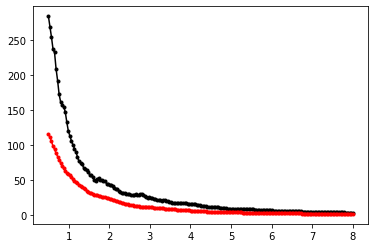

In [34]:
ecc = np.linspace(0.5, 8, 200)
plt.plot(ecc, cm(ecc, np.zeros(len(ecc))), 'k.-')
plt.plot(ecc, cm(np.zeros(len(ecc)), ecc), 'r.-')

In [41]:
vmesh = ny.vision.visual_field_mesh(hemi='lh')

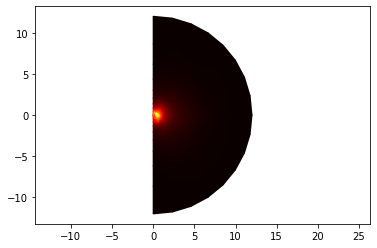

In [48]:
(x, y) = vmesh.coordinates
vmesh_cmag = cm(x, y)

ny.cortex_plot(vmesh, color=vmesh_cmag, underlay=None, cmap='hot')
plt.axis('equal')

pass

In [53]:
# Example label file loading:
# We load from this path:
labels_path = '/data/crcns2021/results/data_branch/save/lindazelinzhao'
# We want to load this hemisphere and this subject ID:
h = 'lh'
sid = 111312

# We load fro this path:
print(f'{labels_path}/{h}_{sid}.mgz')
# Here, we load the data:
lbl = ny.load(f'{labels_path}/{h}_{sid}.mgz')

# The lbl variable contains a vector of values that are 0, 1, 2, or 3.
# There is one value per vertex in the subject's hemisphere; the values
# are:
#  0 means not in hV4, VO1, or VO2
#  1 means the vertex is in hV4
#  2 means the vertex is in VO1
#  3 means the vertex is in VO2

/data/crcns2021/results/data_branch/save/lindazelinzhao/lh_111312.mgz


In [55]:
np.unique(lbl)

array([0, 1, 2, 3], dtype=int32)

In [59]:
h = 'lh'
sid = 111312

# Load in some other data for the subject we picked in the cell above.
sub = ny.data['hcp_lines'].subjects[sid]
hem = sub.hemis[h]

# Make a flatmap for easy 2D plots:
fmap = ny.to_flatmap('occipital_pole', hem)

In [62]:
hem.prop('prf_eccentricity')

array([1.8923963, 1.8923963, 1.3929757, ..., 6.53489  , 1.1696   ,
       1.1696   ], dtype=float32)

In [66]:
# label 1: hV4 (positive field sign)
# label 2: VO1 (negative field sign)
# label 2: VO2 (positive field sign)
cleaned_ret = ny.vision.clean_retinotopy(
    hem,
    retinotopy='prf_',
    visual_area=lbl,
    visual_area_field_signs={1:1, 2:-1, 3:1})

In [81]:
retinotopy = {'polar_angle': cleaned_ret[0],
              'eccentricity': cleaned_ret[1]}
cm = ny.vision.areal_cmag(hem, mask=(lbl == 1), retinotopy=retinotopy)

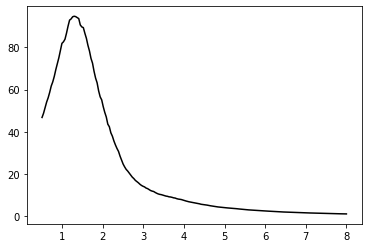

In [101]:
ecc = np.linspace(0.5, 8, 200)
plt.plot(ecc, cm(ecc, np.zeros_like(ecc)), 'k-')

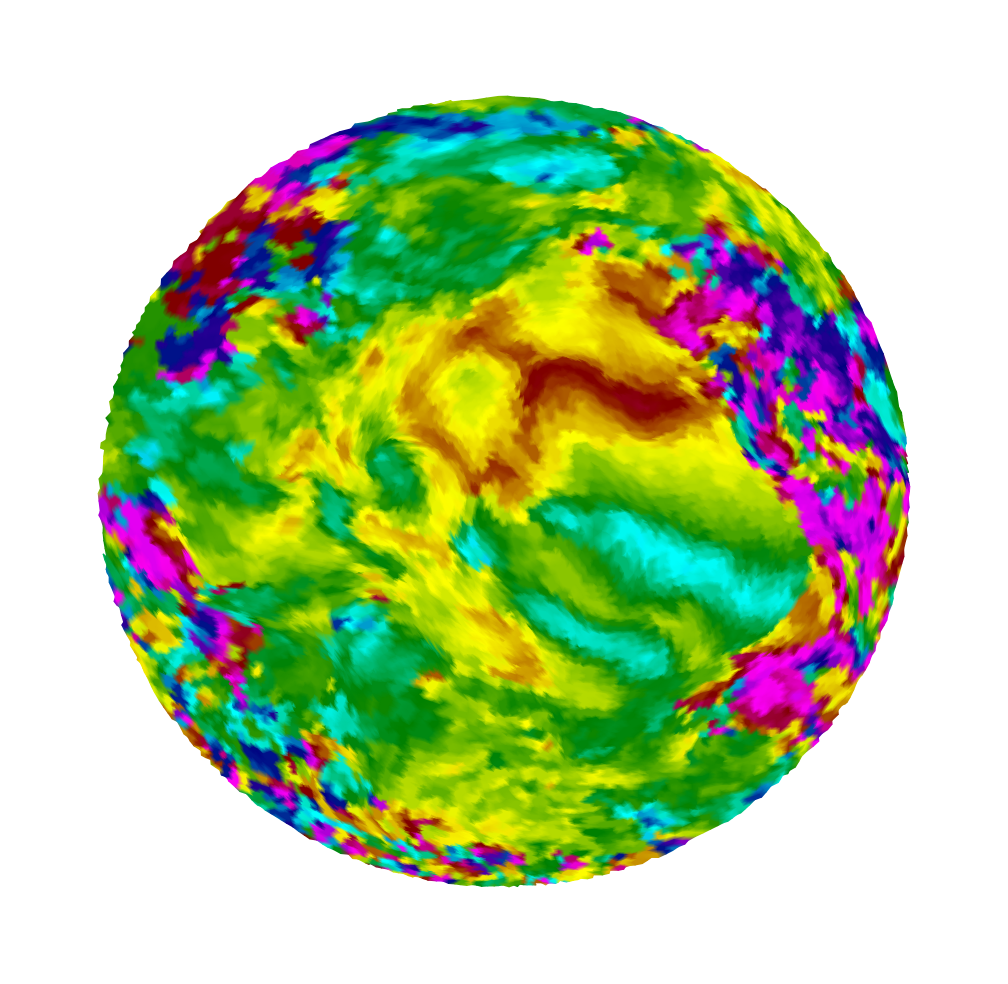

In [64]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=72*8)
ny.cortex_plot(fmap, color='prf_polar_angle', axes=ax)
ax.axis('off')

pass

In [106]:
.shape

(29661,)

In [105]:
fmap.vertex_count

29661

In [112]:
(x_im, y_im) = np.meshgrid(np.linspace(-1, 1, 100),
                           np.linspace(9, 11, 100))

In [117]:
np.array_equal(y_im[:,0], y_im[:,1])

True

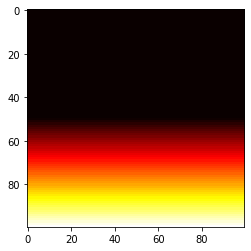

In [120]:
plt.imshow(y_im, cmap='hot', vmin=10, vmax=11)

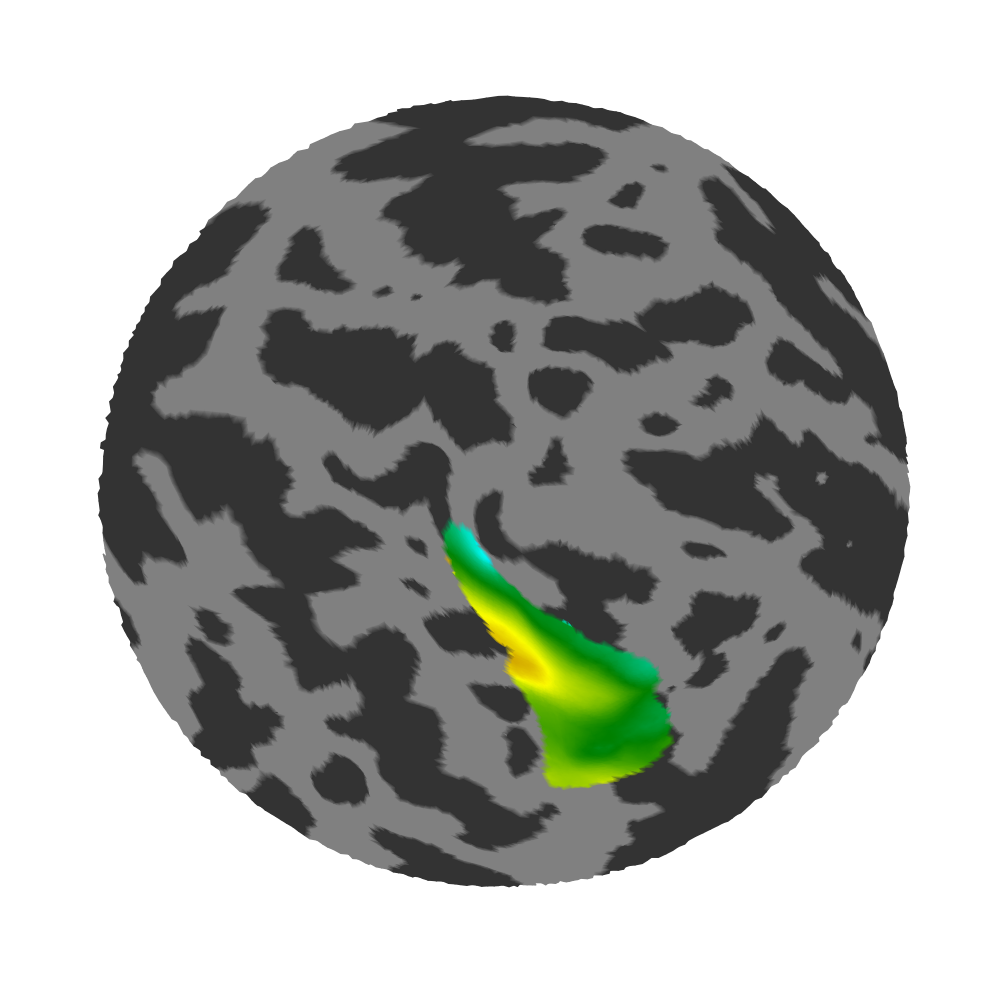

In [122]:
polar_angle = cleaned_ret[0][fmap.labels]
eccentricity = cleaned_ret[1][fmap.labels]

(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=72*8)

ny.cortex_plot(fmap, color=polar_angle,
               cmap='polar_angle', vmin=-180, vmax=180,
               mask=(np.isfinite(polar_angle)),
               axes=ax)

ax.axis('off')

pass

In [136]:
hv4_lbl = (lbl == 1)
ecc = hem.prop('prf_eccentricity')[hv4_lbl]
surfarea = hem.prop('midgray_surface_area')[hv4_lbl]

ecc_order = np.argsort(ecc)

ecc_sorted = ecc[ecc_order]
surfarea_sorted = surfarea[ecc_order]

total_surfarea = np.sum(surfarea)
cumsum_surfarea = np.cumsum(surfarea_sorted)
half_yet = (cumsum_surfarea > (total_surfarea/2))
ii = np.argmax(half_yet)
ecc_sorted[ii]

1.4464964

In [182]:
def find_halfeccen(hem, mask,
                   eccentricity='prf_eccentricity',
                   surface_area='midgray_surface_area'):
    """Finds the eccentricity in an ROI that divides the ROI in half.
    
    Parameters
    ----------
    hem : neuropythy Cortex object
        The hemisphere/cortex on which the calculation is being performed.
    mask : neuropythy-mask-like object
        Any argument that specifies the ROI in which the calculation should
        be performed. Any argument that can be passed to neuropythy's
        `to_mask` function can be used.
    eccentricity : str or vector
        The eccentricity property for the hemisphere; may be a property name
        or a vector of eccentricity values for each vertex.
    surface_area : str or vector
        The surface area property for the hemisphere; may be a property name
        or a vector of surface area values for each vertex.
    
    Returns
    -------
    float
        The eccentricity at which the ROI is divided into two pieces with
        equal surface areas.
    """
    # Convert the mask into labels:
    mask = hem.mask(mask, indices=True)
    if len(mask) < 2:
        return np.nan
    # Process the eccentricity and surface_area arguments into vectors:
    eccentricity = hem.property(eccentricity)
    surface_area = hem.property(surface_area)
    # Apply the mask to the eccen and surface area:
    eccentricity = eccentricity[mask]
    surface_area = surface_area[mask]
    # Sort the vertices by eccentricity:
    ecc_order = np.argsort(eccentricity)
    # Extract the eccen and surface area in sorted order:
    ecc_sorted = eccentricity[ecc_order]
    surfarea_sorted = surface_area[ecc_order]
    # Find the total (and half-) surface area of the ROI:
    total_surfarea = np.sum(surface_area)
    # Calculate the cumulative sum of surface area (in sorted eccen order):
    cumsum_surfarea = np.cumsum(surfarea_sorted)
    # Find where the cumulative sum of surface area for vertices is more
    # than half of the total surface area:
    half_yet = (cumsum_surfarea > (total_surfarea/2))
    # The half_yet vector is a list of 0s (for each vertex whose cumsum
    # surface area is less than half the total surface area) followed by
    # a list of 1s (for each vertex whose cumsum is greater than half).
    # The argmax function will return the position of the first 1.
    ii = np.argmax(half_yet)
    # At this point, vertex ii is just past the half-way point.
    if ii == 0:
        return np.nan
    return (ecc_sorted[ii] + ecc_sorted[ii-1]) / 2

In [183]:
def accumulate_halfeccens(rater_list, sid_list, mask_dict, cache_filename,
                          label_file_template,
                          eccentricity='prf_eccentricity',
                          surface_area='midgray_surface_area'):
    """Runs the find_halfeccen function for the list of raters and sids.
    
    Parameters
    ----------
    rater_list : list of raters
        The raters to calculate the halfeccen for.
    sid_list : list of subjects
        The subject IDs for subjects to calculate the halfeccen for.
    mask_dict : dict of neuropythy-mask-like object
        A dictionary whose keys are the names of the ROIs to use in the table
        and whose values are masks to be passed to find_halfeccen.
    cache_filename : path-like
        The path of the file to which we want to save progress.
    label_file_template : path-like
        A template string for the label files. This string should be ready to
        have the `format` method called with parameters named `rater`, `sid`,
        and `hemisphere`. For example:
        `"some_path/{rater}/{hemisphere}_{sid}.mgz"`
    eccentricity : str or vector
        The eccentricity property for the hemisphere; may be a property name
        or a vector of eccentricity values for each vertex.
    surface_area : str or vector
        The surface area property for the hemisphere; may be a property name
        or a vector of surface area values for each vertex.

    Returns
    -------
    pandas DataFrame
        A table of all the half-eccens for all raters, sids, and hemispheres.
    """
    # First step is to check to see if there is already a cache file.
    if os.path.isfile(cache_filename):
        # There is already a cache file:
        prog = pandas.read_csv(cache_filename)
    else:
        # We are starting from scratch:
        prog = pandas.DataFrame(
            {'rater':[], 'sid':[], 'hemisphere':[],
             'roi': [], 'halfeccen': []})
    prog = prog.astype(
        {'rater':str, 'sid':int, 'hemisphere':str,
         'roi': str, 'halfeccen': float})
    initial_prog_len = len(prog)
    for sid in sid_list:
        print(f" - Calculating half-eccentricities for sid {sid}...")
        for rater in rater_list:
            for h in ['lh', 'rh']:
                for (roi, lblvalue) in mask_dict.items():
                    # Before we load any data, make sure this row isn't already in
                    # the progress dataframe.
                    sel = prog[(prog['rater'] == rater) &
                               (prog['sid'] == int(sid)) &
                               (prog['hemisphere'] == h) &
                               (prog['roi'] == roi)]
                    if len(sel) > 0:
                        continue
                    # First load the label file for this rater/sid/hemisphere/roi.
                    lbl_file = label_file_template.format(
                        rater=rater,
                        sid=sid,
                        hemisphere=h,
                        roi=roi)
                    if not os.path.isfile(lbl_file):
                        print(f" - Skipping missing label file for {rater} / {sid} / {h} / {roi}")
                        halfeccen = np.nan
                    else:
                        lbl = ny.load(lbl_file)
                        # Load the subject and hemisphere data.
                        sub = ny.data['hcp_lines'].subjects[int(sid)]
                        hem = sub.hemis[h]
                        # Now call the find_halfeccen function using the data we have
                        # loaded.
                        halfeccen = find_halfeccen(
                            hem, (lbl == lblvalue),
                            eccentricity=eccentricity,
                            surface_area=surface_area)
                    # At this point, we have calculated the half-eccen for this
                    # set of data. We need to record it in the dataframe.
                    prog.loc[len(prog)] = [rater, sid, h, roi, halfeccen]
        # Now that we've appended the row to the dataframe, we should
        # re-save the dataframe.
        if len(prog) > initial_prog_len:
            ny.save(cache_filename, prog)
    # At the end of all these loops, we have calculated the half-eccen for every
    # subject ID, rater, hemisphere, and ROI, and we just need to return the
    # dataframe.
    return prog

In [ ]:
rater_list = ['lindazelinzhao','bogengsong','BrendaQiu','jennifertepan','JiyeongHa','nourahboujaber']
sid_list = ny.data['hcp_lines'].subject_list
mask_dict = {'hV4': 1, 'VO1': 2, 'VO2': 3}
cache_filename = "halfeccen_data.csv"

labels_path = '/data/crcns2021/results/data_branch/save'
label_file_template = os.path.join(labels_path, "{rater}/{hemisphere}_{sid}.mgz")

df = accumulate_halfeccens(
    rater_list, sid_list, mask_dict,
    cache_filename,
    label_file_template)